In [50]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import timeit
from PIL import Image
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import matplotlib.pyplot as plt



### Data Preparation

#### create generator of infected and uninfected images

In [53]:
infected = (image for image in os.listdir('Parasitized'))
uninfected = (image for image in os.listdir('Uninfected'))
data = []
labels = []


#### convert images to grayscale, and resize to 50x50 

In [54]:
def transform_images():
    """ convert color images to grayscale, resize"""
    for img in infected:
        image = cv2.imread('./Parasitized/' + img)
        # image = cv2.imread('./Parasitized/' + img, cv2.IMREAD_GRAYSCALE)
        image_array = Image.fromarray(image)  # create PIL image
        resize_img = image_array.resize((50, 50))  # returns resized copy of image
        """
        blurring the image reduces noise 
        Blurs/smooths an image using the normalized box filter
        """
        # blur_image = cv2.blur(np.array(resize_img), (50,50))
        data.append(np.array(resize_img))
        labels.append(1)

    for img in uninfected:
        image = cv2.imread('./Uninfected/' + img)
        # image = cv2.imread('./Uninfected/' + img, cv2.IMREAD_GRAYSCALE)
        image_array = Image.fromarray(image)  # create PIL image
        resize_img = image_array.resize((50, 50))  # returns resized copy of image
        # blur_image = cv2.blur(np.array(resize_img), (50,50))
        data.append(np.array(resize_img))
        labels.append(0)

transform_images()


#### convert to numpy ndarray

In [55]:
cells = np.array(data).astype('float64')
labels = np.array(labels).astype('float64')


#### inspect images

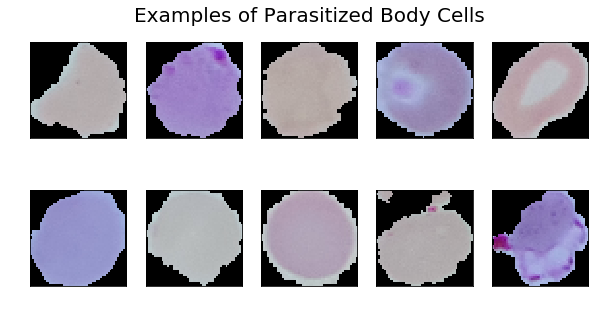

In [56]:
np.random.seed(155)
random_10 = np.random.randint(0,cells.shape[0],size=10)
fig=plt.figure(figsize=(10,5))
plt.title("Examples of Parasitized/Healthy Body Cells",fontsize=20)
plt.axis('off')
for ind,rand in enumerate(random_10):
    ax_n=fig.add_subplot(2,5,ind+1)
    ax_n.imshow(cells[rand])
    ax_n.get_xaxis().set_visible(False)
    ax_n.get_yaxis().set_visible(False)
plt.show()


#### standardize ndarray (scale, center)

#### save ndarray to disk

In [50]:
np.save('Cells', cells) 
np.save('Labels', labels) 

In [57]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))


Cells : (27558, 50, 50, 3) | labels : (27558,)


#### flatten the 50x50x3 or 50x50 dimensions into a feature vector of 7500 or 2500 values 
+ demensions for color images are 50x50x3 and 50x50 for grayscale

In [58]:
cells_flattened = cells[:].reshape(-1,7500)

In [59]:
cells_flattened.shape


(27558, 7500)

In [60]:
scaler = StandardScaler()
pre_process = scaler.fit(cells_flattened)
cells_flattened = pre_process.transform(cells_flattened)


/Users/asoa/python_v/opencv/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/asoa/python_v/opencv/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### create train/test dataset

In [61]:
x_train, x_test, y_train, y_test = train_test_split(cells_flattened, labels, train_size=0.7, test_size=0.3, random_state=155)


### Model development

#### GridSearchCV wrapper implements cross validation and scoring metric
+ https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [62]:
parameters = [{'n_neighbors':[1,2,3,4,5], 'algorithm':['brute'], 'metric':['minkowski']}]
grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=2, n_jobs=4, scoring='recall')
grid_search.fit(x_train, y_train)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5], 'algorithm': ['brute'], 'metric': ['minkowski']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

#### print best results from grid search

In [63]:
grid_search.best_params_
    

{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1}

### Performance metrics

In [64]:
results = grid_search.predict(x_test)

In [44]:
confusion_matrix(y_test, results)

array([[3652,  522],
       [2961, 1133]])

In [65]:
print(f"Accuracy: {accuracy_score(y_test, results)}")
print(f"Recall: {recall_score(y_test, results)}")
print(classification_report(y_test, results))



Accuracy: 0.5858732462506048
Recall: 0.30508060576453344
              precision    recall  f1-score   support

           0       0.56      0.86      0.68      4174
           1       0.68      0.31      0.42      4094

   micro avg       0.59      0.59      0.59      8268
   macro avg       0.62      0.58      0.55      8268
weighted avg       0.62      0.59      0.55      8268



### Support Vector Machine model development
+ L1 regularization (LinearSVC) to reduce feature space set by 'penalty':'l1'
+ L1 regularization (SVC) to reduce feature space is implemented using the shrinking=True (default)
+ gamma default (SVC) is 1 / n_features -> 1/shape[1] 
+ for LinearSVC(), set dual=False per the documentation 

In [69]:
start = timeit.default_timer()
# svm_parameters = [{'kernel':['linear'], 'gamma':[.01], 'C':[1]}]  # SVC()
svm_parameters = [{'penalty':['l1'],'loss':['squared_hinge'],'dual':[False],'random_state':[155],'C':[0.1, 1],'max_iter':[10000]}]
grid_search_svm = GridSearchCV(LinearSVC(), svm_parameters, cv=2, n_jobs=-1, scoring='recall')
grid_search_svm.fit(x_train, y_train)
print(f'Runtime for SVM:{timeit.default_timer() - start}')


Runtime for SVM:5729.364280961


/Users/asoa/python_v/opencv/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### print best performing model

In [70]:
grid_search_svm.best_params_


{'C': 0.1,
 'dual': False,
 'loss': 'squared_hinge',
 'max_iter': 10000,
 'penalty': 'l1',
 'random_state': 155}

### SVM performance metrics
+ https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [71]:
svm_results = grid_search_svm.predict(x_test)

In [ ]:
confusion_matrix(y_test, svm_results)

In [74]:
print(f"Accuracy: {accuracy_score(y_test, svm_results)}")
print(f"Recall: {recall_score(y_test, svm_results)}")
print(classification_report(y_test, svm_results))



Accuracy: 0.6756168359941945
Recall: 0.6409379579872985
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      4174
           1       0.68      0.64      0.66      4094

   micro avg       0.68      0.68      0.68      8268
   macro avg       0.68      0.68      0.68      8268
weighted avg       0.68      0.68      0.68      8268



### Pickle the model to disk
+ https://scikit-learn.org/stable/modules/model_persistence.html
+ load it from disk: clf = load('svm_model.joblib') -> clf.predict(<x>)

In [73]:
dump(grid_search_svm, 'svm_model.joblib')


['svm_model.joblib']